In [1]:
import csv
import numpy as np
import pandas as pd


In [17]:
import pandas as pd

# Function to process the CSV file
def process_csv(input_file, output_file):
    # Read the CSV file in chunks
    chunks = pd.read_csv(input_file, chunksize=100000)  # Adjust chunksize as needed
    df_list = []

    for chunk in chunks:
        # Concatenate the first 5 columns into an identifier column
        chunk['identifier'] = chunk.apply(lambda x: f"{x['ip']}-{x['app']}-{x['device']}-{x['os']}-{x['channel']}", axis=1)
        
        # Calculate the frequency of each identifier
        chunk['frequency'] = chunk.groupby('identifier')['identifier'].transform('count')
        
        # Keep the maximum value of 'is_attributed' for each identifier group
        chunk['is_attributed'] = chunk.groupby('identifier')['is_attributed'].transform('max')
        
        # Reorder the columns to make 'identifier' the first column
        chunk = chunk[['identifier', 'ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'frequency']]
        
        df_list.append(chunk)

    # Concatenate all chunks into a single DataFrame
    final_df = pd.concat(df_list, ignore_index=True)
    final_df.drop_duplicates(subset='identifier', inplace=True)

    # Write the processed DataFrame to a new CSV file
    final_df.to_csv(output_file, index=False)

# Main execution
if __name__ == "__main__":
    input_csv_file = './data/24h_full.csv'  # Specify your input CSV file path
    output_csv_file = './data/24h_processed_isattributed.csv'  # Specify your output CSV file path
    process_csv(input_csv_file, output_csv_file)


Histogram maker

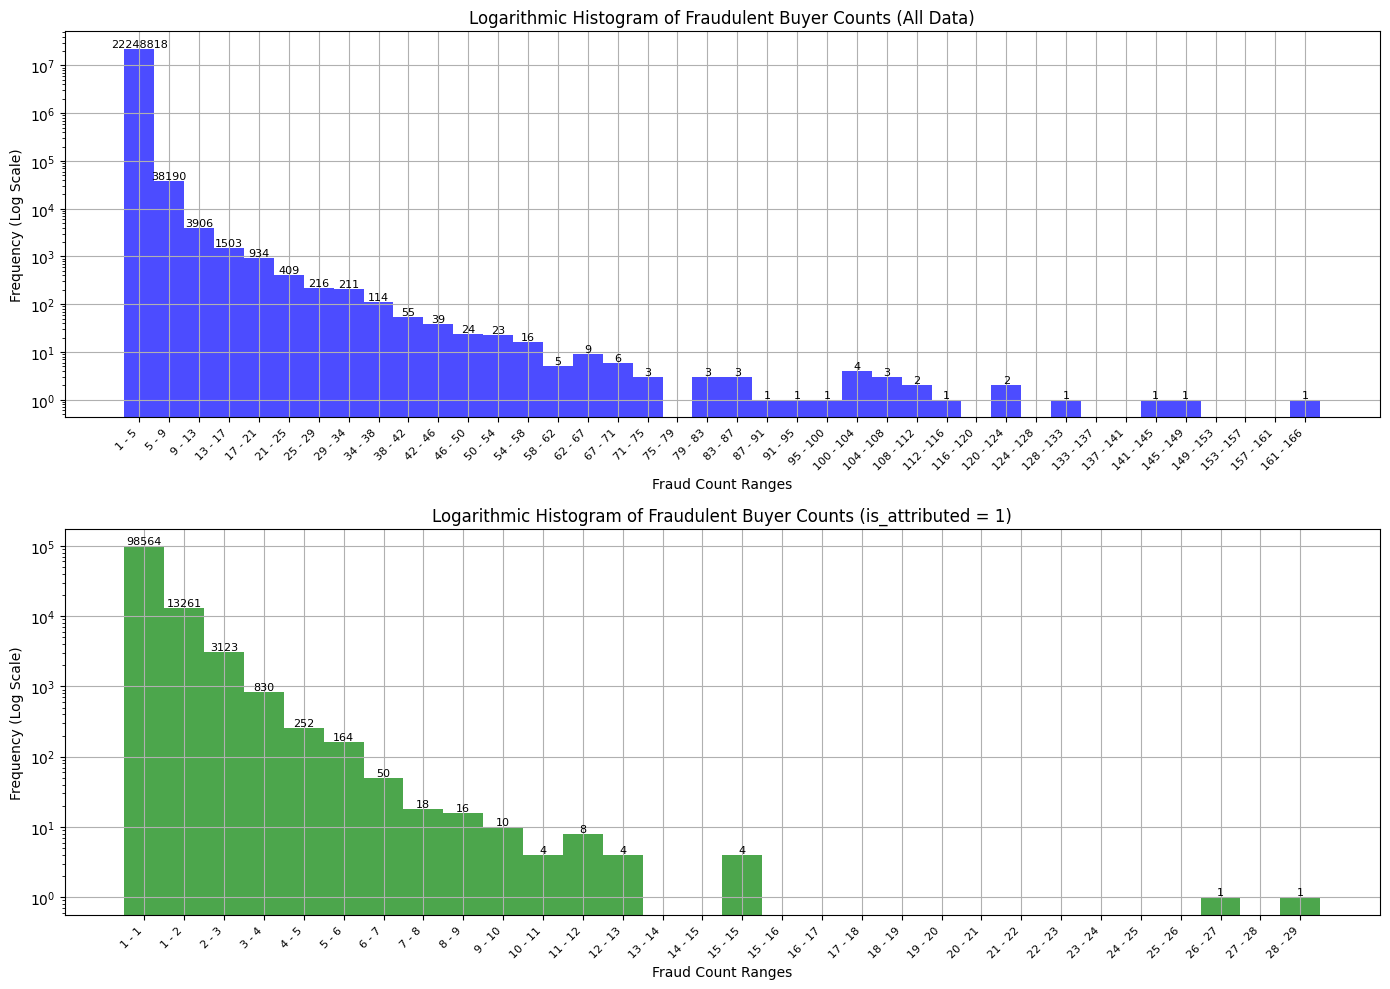

In [22]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Load the CSV file into a Dask DataFrame
csv_file_path = './data/24h_processed_isattributed.csv'  # Update this with the path to your CSV file
ddf = dd.read_csv(csv_file_path)

# Extract the 'frequency' column as a Dask Series for all data
values_all = ddf['frequency'].compute().tolist()

# Extract the 'frequency' column for subset where 'is_attributed' is 1
values_attributed = ddf[ddf['is_attributed'] == 1]['frequency'].compute().tolist()

# Create the plot figure
plt.figure(figsize=(14, 10))

# Plot histogram for all data
plt.subplot(2, 1, 1)
n_all, bins_all, patches_all = plt.hist(values_all, bins=40, color='blue', alpha=0.7)
plt.yscale('log')
bin_centers_all = 0.5 * (bins_all[1:] + bins_all[:-1])
for count, x in zip(n_all, bin_centers_all):
    if count > 0:  # Add label only if count is greater than 0
        plt.text(x, count, f'{int(count)}', ha='center', va='bottom', fontsize=8)
bin_labels_all = [f'{int(bins_all[i])} - {int(bins_all[i+1])}' for i in range(len(bins_all) - 1)]
plt.xticks(bin_centers_all, bin_labels_all, rotation=45, ha='right', fontsize=8)
plt.title('Logarithmic Histogram of Fraudulent Buyer Counts (All Data)')
plt.xlabel('Fraud Count Ranges')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)

# Plot histogram for data where 'is_attributed' is 1
plt.subplot(2, 1, 2)
n_attr, bins_attr, patches_attr = plt.hist(values_attributed, bins=30, color='green', alpha=0.7)
plt.yscale('log')
bin_centers_attr = 0.5 * (bins_attr[1:] + bins_attr[:-1])
for count, x in zip(n_attr, bin_centers_attr):
    if count > 0:  # Add label only if count is greater than 0
        plt.text(x, count, f'{int(count)}', ha='center', va='bottom', fontsize=8)
bin_labels_attr = [f'{int(bins_attr[i])} - {int(bins_attr[i+1])}' for i in range(len(bins_attr) - 1)]
plt.xticks(bin_centers_attr, bin_labels_attr, rotation=45, ha='right', fontsize=8)
plt.title('Logarithmic Histogram of Fraudulent Buyer Counts (is_attributed = 1)')
plt.xlabel('Fraud Count Ranges')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()



Bargraph maker


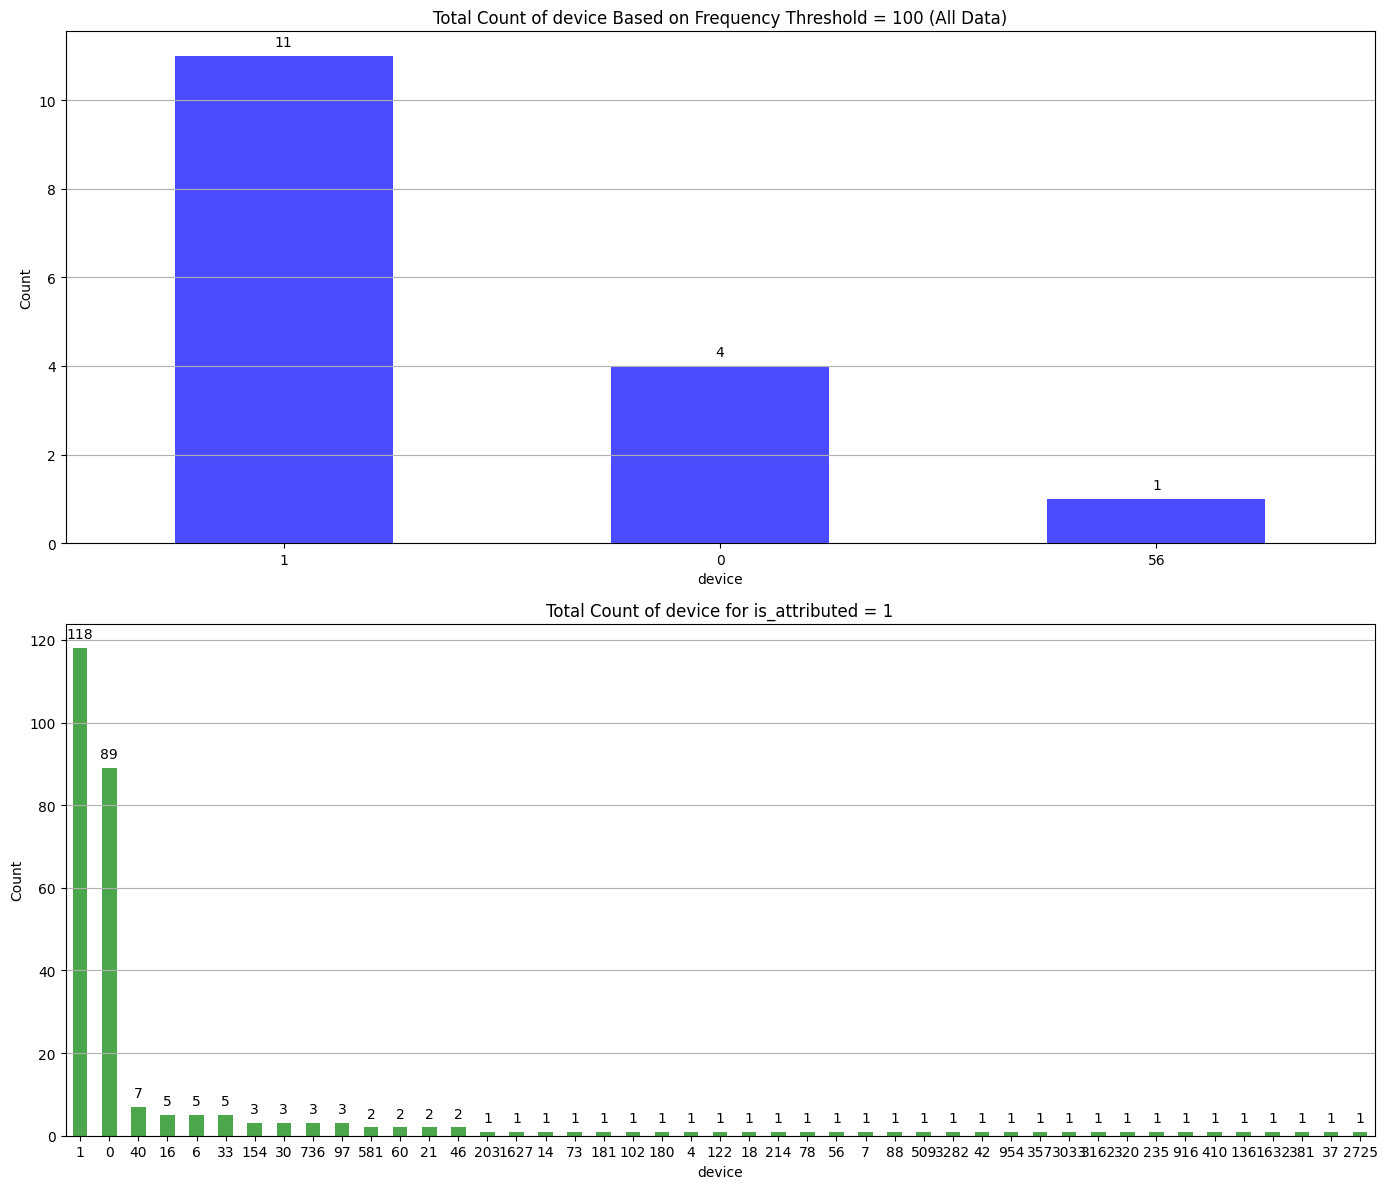

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file_path = './data/24h_processed_isattributed.csv'  # Update this with the path to your CSV file
df = pd.read_csv(csv_file_path)

# Measurement
measurement = 'device'  # Choose the measurement to plot ('device', 'app', 'os', 'channel')

# Define a frequency threshold
frequency_threshold = 100  # Set your desired threshold
attributed_threshold = frequency_threshold / 20  # Set a threshold for is_attributed = 1

# Filter the full dataset based on the frequency threshold
filtered_df = df[df['frequency'] > frequency_threshold]

# Create the subset where is_attributed == 1 (without applying the threshold)
subset_df_attributed = df[(df['is_attributed'] == 1) & (df['frequency'] > attributed_threshold)]


# Count occurrences of each measurement in both datasets
measurement_counts_all = filtered_df[measurement].value_counts()
measurement_counts_attributed = subset_df_attributed[measurement].value_counts()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot for all data after frequency filtering
if not measurement_counts_all.empty:
    measurement_counts_all.plot(kind='bar', color='blue', alpha=0.7, ax=axes[0])
    axes[0].set_title(f'Total Count of {measurement} Based on Frequency Threshold = {frequency_threshold} (All Data)')
    axes[0].set_xlabel(f'{measurement}')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y')
    axes[0].tick_params(axis='x', rotation=0)

    # Add labels on top of each bar for all data
    for p in axes[0].patches:
        if p.get_height() > 0:  # Add label only if count is greater than 0
            axes[0].annotate(
                str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
else:
    axes[0].text(0.5, 0.5, 'No data available for the selected threshold (All Data)', 
                 horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize=12)
    axes[0].set_axis_off()

# Plot for data where is_attributed == 1 (without frequency filtering)
if not measurement_counts_attributed.empty:
    measurement_counts_attributed.plot(kind='bar', color='green', alpha=0.7, ax=axes[1])
    axes[1].set_title(f'Total Count of {measurement} for is_attributed = 1')
    axes[1].set_xlabel(f'{measurement}')
    axes[1].set_ylabel('Count')
    axes[1].grid(axis='y')
    axes[1].tick_params(axis='x', rotation=0)

    # Add labels on top of each bar for data with is_attributed = 1
    for p in axes[1].patches:
        if p.get_height() > 0:  # Add label only if count is greater than 0
            axes[1].annotate(
                str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
else:
    axes[1].text(0.5, 0.5, 'No data available for is_attributed = 1', 
                 horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_axis_off()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

